# Obstacles to State Preparation and Variational Optimization from Symmetry Protection


## 项目介绍


[Obstacles to State Preparation and Variational Optimization from Symmetry Protection](https://arxiv.org/pdf/1910.08980.pdf)

文章提出的Recursive-QAOA方案能极大提高求解成果率，利用MindQuantum复现论文图Fig1类似结果，节点数为20，nc取值不大于8。（文章对一层的QAOA线路直接得到解析结果，这里使用模拟器搭建线路实现）

Local Hamiltonians with topological quantum order exhibit highly entangled ground states that cannot be prepared by shallow quantum circuits. Here, we show that this property may extend to all low-energy states in the presence of an on-site Z2 symmetry. This proves a version of the No Low-Energy Trivial States (NLTS) conjecture for a family of local Hamiltonians with symmetry protected topological order. A surprising consequence of this result is that the Goemans-Williamson algorithm outperforms the Quantum Approximate Optimization Algorithm (QAOA) for certain instances of MaxCut, at any constant level. We argue that the locality and symmetry of QAOA severely limits its performance. To overcome these limitations, we propose a non-local version of QAOA, and give numerical evidence that it significantly outperforms standard QAOA for frustrated Ising models on random 3-regular graphs.

![article fragments](./img/article1.png)

## 算法原理

#### Recursive Quantum Approximate Optimization Algorithm
循环量子近似优化算法(RQAOA, recursive quantum approximate optimization algorithm)

考虑一个根据n顶点图$G_n=(V,E)$定义的类Ising哈密顿量
$$H_n=\sum_{(p,q)\in E}{J_{p,q}Z_pZ_q}$$
其中$J_{p,q}$是$G_n$各边的权重，可以为任意实系数。

RQAOA的目标是近似能量最小值$min_z\langle z\lvert H_n\rvert z \rangle$，其中$z \in \{1,-1\}^n$

#### eliminateVariable
RQAOA比QAOA多了个Recursive——循环——在循环中不断根据QAOA的运行结果来消除变量，相当于消除$G_n$的顶点。因此消元(eliminate variable)这步至关重要。

eliminateVariable一般流程：

1.运行深度p的标准QAOA来找到一个期望最小化$min\langle \Psi^*\lvert H_n\rvert\Psi \rangle$的量子态$\Psi$；

2.对优化后的量子态$\Psi$按照每条边$e=(i,j)\in E$测量得到$M_e=\langle \Psi^*\lvert Z_iZ_j\rvert\Psi \rangle$；

3.找到边$f=argmax_{f\in E}\lvert M_f\rvert$，并随机选取顶点$v\in f$,再取出其符号$\sigma=sign(M_f)$；

4.利用$f,v,\sigma$对$H_n$施加约束$Z_v=\sigma Z_{f\setminus\{v\}}$,即可得到新Ising哈密顿量$H_{n-1}$，也就是消除了图$G_n$的一个顶点生成新图$G_{n-1}$，同时记录下$\xi=(v,f\setminus\{v\},\sigma)$（具体公式参考论文中C.1.）。

#### RQAOA

循环地调用eliminateVariable即可将n顶点图$G_n$消元至$n_c$顶点图$G_{n_c}$，其中$n_c\ll n$为指定的阈值。

对于$G_{n_c}$即可用暴力法等方法求解，再根据迭代过程中保存的$\xi$们逆推出$G_n$的解。

## 复现过程

In [ ]:
## 安装最新版Minduantum

!pip install https://hiq.huaweicloud.com/download/mindquantum/newest/linux/mindquantum-master-cp37-cp37m-linux_x86_64.whl -i https://pypi.tuna.tsinghua.edu.cn/simple

In [1]:
from src.rqaoa import rqaoa                                   # RQAOA
from src.rqaoa import rqaoa_recursion, rqaoa_translate        # RQAOA 分解
from src.utils import generate_graph                          # 测试图结构
from src.utils import maxcut_enum                             # 枚举法求解MaxCut
from src.qaoa import qaoa, get_partition, get_expectation     # QAOA

import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### 1.先在10节点的小小图上测试一下

#### 1.1.生成图结构

random 3-regular graphs and random couplings $J_{p,q} = ±1$

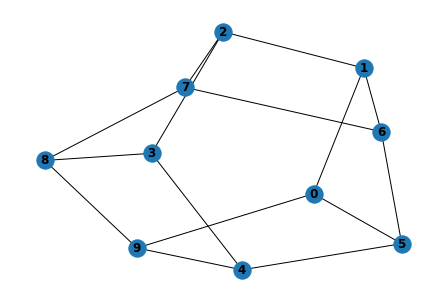

In [2]:
g = generate_graph(10)  # 生成图结构
nx.draw(g, with_labels=True, font_weight='bold')

In [3]:
# Use a greedy one exchange strategy to find a locally maximal cut and its value
nx.algorithms.approximation.maxcut.one_exchange(g, weight='J')

(5, ({1, 2, 5}, {0, 3, 4, 6, 7, 8, 9}))

In [4]:
maxcut_enum(g, 'J')  # 枚举法得到最大切割数

(5, [5, 2, 1])

对于$H_n=\sum_{p,q\in E}J_{p,q}Z_pZ_q,z\in \{-1, 1\}^n$

最小值可认为为$E_{min}=min_z\langle z|H_n|z \rangle =Const.-2C_{max}$

In [8]:
C_max = 5

#### 1.2.RQAOA

$level=1, n_c=6$

In [5]:
res_rqaoa = rqaoa(g, 6, 1, True)  # rqaoa(graph, nc, level, iter_show)

RQAOA started!
--------------------------
nodes_num: 10
edges_num: 15
>>> eliminated variable: 4
>>> correlated variable: 5
>>> σ: -1
--------------------------
nodes_num: 9
edges_num: 14
>>> eliminated variable: 7
>>> correlated variable: 2
>>> σ: -1
--------------------------
nodes_num: 8
edges_num: 13
>>> eliminated variable: 8
>>> correlated variable: 3
>>> σ: 1
--------------------------
nodes_num: 7
edges_num: 11
>>> eliminated variable: 3
>>> correlated variable: 2
>>> σ: -1
--------------------------
nodes_num: 6
edges_num: 10
Result of MaxCut: {0: 1, 1: -1, 9: 1, 5: -1, 2: -1, 6: 1}
--------------------------
Result of RQAOA: {0: 1, 1: -1, 9: 1, 5: -1, 2: -1, 6: 1, 3: 1, 8: 1, 7: 1, 4: 1}
--------------------------
RQAOA ended!


#### 1.3.处理RQAOA结果

In [6]:
l_rqaoa = []
for k in res_rqaoa:
    if res_rqaoa[k] == -1:
        l_rqaoa.append(k)
print(l_rqaoa)
nx.cut_size(g, l_rqaoa, weight='J')  # 最大切割值（带权重）

[1, 5, 2]


5

In [9]:
C_rqaoa = 5

#### 1.4.QAOA

$depth=1$

In [7]:
circ, pr = qaoa(g, 'J', 1, 100)  # qaoa(graph, weight_key, depth, step, learning_rate, monitor)
res_qaoa = get_partition(g, circ, pr)[0]  # get_partition(graph, circ, pr, max_n)
l_qaoa = []
for k in res_qaoa:
    if res_qaoa[k] == -1:
        l_qaoa.append(k)
print(l_qaoa)
nx.cut_size(g, l_qaoa, weight='J')

[0, 3, 4, 6, 7, 8, 9]


5

In [10]:
C_qaoa = 5

#### 1.5.论文图Fig1类似结果

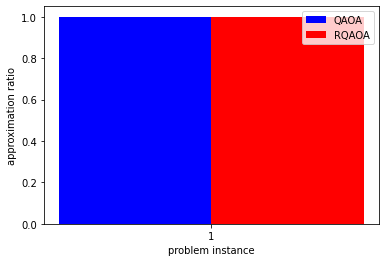

In [11]:
width = 0.5
fig, ax = plt.subplots()
ax.bar([0], [C_qaoa/C_max], width=width, label='QAOA', color='blue')
ax.bar([0+width], [C_rqaoa/C_max], width=width, label='RQAOA', color='red')
ax.set_xlabel('problem instance')
ax.set_ylabel('approximation ratio')
ax.set_xticks([0.25])
ax.set_xticklabels([1])
ax.legend()
plt.show()

FIG. 1: Approximation ratios achieved by the level-1 QAOA (blue) and RQAOA (red) for the Ising-type
Hamiltonian $H_n$ with n = 10. We consider 1 problem instances with random 3-regular graphs and random couplings $J_{p,q} = ±1$. The cutoff value for variable elimination was chosen as $n_c = 6$. The approximation ratio achieved by a given algorithm is defined as $\langle z|C_n|z \rangle /C_{max}$, where $z\in \{-1, 1\}^n$ is the algorithm’s output and $C_{max} = max_z\langle z|C_n|z \rangle$ where $C_n = \frac{1}{2}(\sum J_e-H_n)$.

额感觉不大对啊

QAOA对应的approximation ratio中的$|z \rangle$换成QAOA解出的叠加态试试

In [16]:
expect = get_expectation(g, circ, pr, 'J')
J = 0
for i in g.edges:
    J += g.edges[i]['J']
C_qaoa_expect = (J - expect.real) / 2
print(C_qaoa_expect)

1.3866540262227534


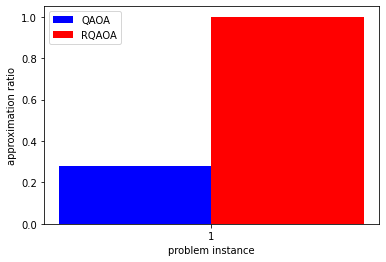

In [18]:
width = 0.5
fig, ax = plt.subplots()
ax.bar([0], [C_qaoa_expect/C_max], width=width, label='QAOA', color='blue')
ax.bar([0+width], [C_rqaoa/C_max], width=width, label='RQAOA', color='red')
ax.set_xlabel('problem instance')
ax.set_ylabel('approximation ratio')
ax.set_xticks([0.25])
ax.set_xticklabels([1])
ax.legend()
plt.show()

FIG. 2: Approximation ratios achieved by the level-1 QAOA (blue) and RQAOA (red) for the Ising-type
Hamiltonian $H_n$ with n = 10. We consider 1 problem instances with random 3-regular graphs and random couplings $J_{p,q} = ±1$. The cutoff value for variable elimination was chosen as $n_c = 6$. The approximation ratio achieved by a given algorithm is defined as $\langle z|C_n|z \rangle /C_{max}$, where $z\in \{-1, 1\}^n$ is the algorithm’s output and $C_{max} = max_z\langle z|C_n|z \rangle$ where $C_n = \frac{1}{2}(\sum J_e-H_n)$.

![very good](./img/verygood.png)

### 2.复活点存档

由于20节点对QAOA一层的模拟感觉还是有那么一点点的慢，因此提供分步版的RQAOA，允许保存每次消元后产生的新图g和restricted set Xi。

演示一下

#### 2.1.一个8节点图

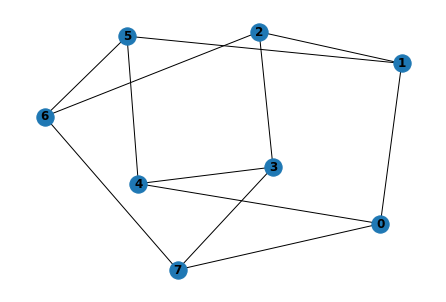

In [2]:
g = generate_graph(8)  # 生成图结构
nx.draw(g, with_labels=True, font_weight='bold')

#### 2.2.消元消到6节点，同时每消去一个节点保存一个checkpoint

In [3]:
path_name = './test1_n8'
Xi = []
g, Xi = rqaoa_recursion(g, nc=6, Xi=Xi, checkpoint=path_name)

--------------------------
nodes_num: 8
edges_num: 12
>>> eliminated variable: 4
>>> correlated variable: 5
>>> σ: -1
--------------------------
nodes_num: 7
edges_num: 11
>>> eliminated variable: 1
>>> correlated variable: 2
>>> σ: -1


#### 2.3.从6节点开始再消去1个节点

start:  6
--------------------------
nodes_num: 6
edges_num: 10
>>> eliminated variable: 7
>>> correlated variable: 6
>>> σ: -1
end:  5


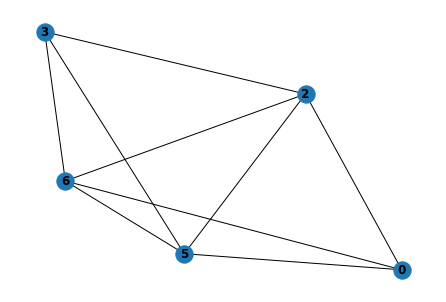

In [4]:
print('start: ', len(g.nodes))
g, Xi = rqaoa_recursion(g, nc=5, Xi=Xi, checkpoint=None)
print('end: ',len(g.nodes))
nx.draw(g, with_labels=True, font_weight='bold')

#### 2.4.枚举法求解5节点图并通过restricted set求解原8节点图

In [5]:
rqaoa_translate(g, Xi)

--------------------------
nodes_num: 5
edges_num: 9
Result of MaxCut: {0: 1, 2: -1, 6: 1, 5: -1, 3: 1}


{0: 1, 2: -1, 6: 1, 5: -1, 3: 1, 7: -1, 1: 1, 4: 1}

这里的分区结果是[0, 6, 3 ,1, 4]哈

#### 2.5.存档点复活

之前在2.2中顺手保存了消元后节点数为7和6的图及对应restricted set

我们取出从8节点消到7节点时的图和restricted set

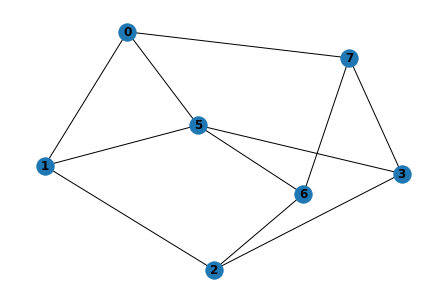

In [7]:
to_n = 7
with open (f'{path_name}_to_n{to_n}.pkl', 'rb') as f:
    cp_n7 = pickle.load(f)
nx.draw(cp_n7['g'], with_labels=True, font_weight='bold')

可以从节点7出发重新消到5一遍

In [8]:
rqaoa_translate(*rqaoa_recursion(cp_n7['g'], 5, cp_n7['Xi']))

--------------------------
nodes_num: 7
edges_num: 11
>>> eliminated variable: 6
>>> correlated variable: 7
>>> σ: -1
--------------------------
nodes_num: 6
edges_num: 10
>>> eliminated variable: 1
>>> correlated variable: 2
>>> σ: -1
--------------------------
nodes_num: 5
edges_num: 9
Result of MaxCut: {0: 1, 2: -1, 7: 1, 5: -1, 3: 1}


{0: 1, 2: -1, 7: 1, 5: -1, 3: 1, 1: 1, 6: -1, 4: 1}

可以看到消元过程可能会出现点不同的

最终结果[0, 7, 3, 1, 4]同2.4中的[0, 6, 3 ,1, 4]也那么点不同欸

### 3.开工！

需要的组件都齐了，下面正式开工~

#### 3.1.主流程演示

节点数为20，nc取值6

#### 3.1.1.生成20节点图

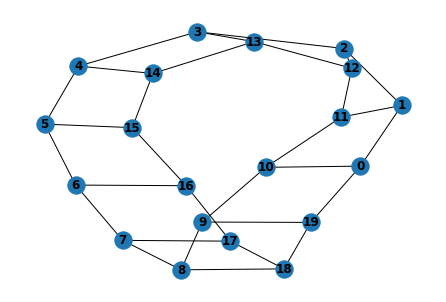

In [9]:
g = generate_graph(20)
nx.draw(g, with_labels=True, font_weight='bold')

枚举法解得最大切割数11

In [10]:
maxcut_enum(g, 'J')

(11, [17, 15, 14, 9, 1])

保存一下图

In [2]:
path_name = './demo/demo/demo_n20'

In [13]:
with open(f'{path_name}.pkl', 'wb') as f:
    pickle.dump({'g': g, 'Xi': []}, f)

#### 3.1.2.将20节点图消减至10节点先

运行下面代码块注释中的程序，迭代过程保存在了`./demo/`文件夹中

我们读取并打印一下迭代过程

In [3]:
"""
import pickle
import time
from src.rqaoa import rqaoa_recursion
nc = 10
path_name = './demo/demo/demo_n20'
with open (f'{path_name}.pkl', 'rb') as f:
    cp_n20 = pickle.load(f)
g, Xi = cp_n20['g'], cp_n20['Xi']
while len(g.nodes) > nc:
    t = time.time()
    g, Xi = rqaoa_recursion(g, len(g.nodes)-1, Xi, checkpoint=path_name)
    print('time:', time.time()-t)
"""
to_n = 10
with open (f'{path_name}_to_n{to_n}.pkl', 'rb') as f:
    cp_n10 = pickle.load(f)
g, Xi = cp_n10['g'], cp_n10['Xi']
n = 20
for xi in Xi:
    print('--------------------------')
    print(f'nodes_num: {n}')
    print(f'>>> eliminated variable: {xi[0]}')
    print(f'>>> correlated variable: {xi[1]}')
    print(f'>>> σ: {xi[2]}')
    n -= 1

--------------------------
nodes_num: 20
>>> eliminated variable: 6
>>> correlated variable: 16
>>> σ: 1
--------------------------
nodes_num: 19
>>> eliminated variable: 15
>>> correlated variable: 5
>>> σ: -1
--------------------------
nodes_num: 18
>>> eliminated variable: 5
>>> correlated variable: 16
>>> σ: 1
--------------------------
nodes_num: 17
>>> eliminated variable: 14
>>> correlated variable: 4
>>> σ: -1
--------------------------
nodes_num: 16
>>> eliminated variable: 16
>>> correlated variable: 4
>>> σ: 1
--------------------------
nodes_num: 15
>>> eliminated variable: 9
>>> correlated variable: 8
>>> σ: -1
--------------------------
nodes_num: 14
>>> eliminated variable: 19
>>> correlated variable: 0
>>> σ: 1
--------------------------
nodes_num: 13
>>> eliminated variable: 17
>>> correlated variable: 18
>>> σ: -1
--------------------------
nodes_num: 12
>>> eliminated variable: 8
>>> correlated variable: 7
>>> σ: 1
--------------------------
nodes_num: 11
>>> elimina

#### 3.1.3.将10节点图消减至nc并求解出原图的MaxCut分区情况

In [4]:
nc = 6
res_rqaoa = rqaoa_translate(*rqaoa_recursion(g, nc, Xi))
print('--------------------------')
print(f'Result of RQAOA: {res_rqaoa}')

--------------------------
nodes_num: 10
edges_num: 13
>>> eliminated variable: 7
>>> correlated variable: 10
>>> σ: 1
--------------------------
nodes_num: 9
edges_num: 12
>>> eliminated variable: 10
>>> correlated variable: 0
>>> σ: 1
--------------------------
nodes_num: 8
edges_num: 11
>>> eliminated variable: 1
>>> correlated variable: 0
>>> σ: -1
--------------------------
nodes_num: 7
edges_num: 9
>>> eliminated variable: 11
>>> correlated variable: 0
>>> σ: 1
--------------------------
nodes_num: 6
edges_num: 8
Result of MaxCut: {0: 1, 2: 1, 12: 1, 3: 1, 4: 1, 13: 1}
--------------------------
Result of RQAOA: {0: 1, 2: 1, 12: 1, 3: 1, 4: 1, 13: 1, 11: 1, 1: -1, 10: 1, 7: 1, 18: 1, 8: 1, 17: -1, 19: 1, 9: -1, 16: 1, 14: -1, 5: 1, 15: -1, 6: 1}


In [5]:
l_rqaoa = []
for k in res_rqaoa:
    if res_rqaoa[k] == -1:
        l_rqaoa.append(k)
print(f'Result of RQAOA: {l_rqaoa}')

Result of RQAOA: [1, 17, 9, 14, 15]


In [3]:
with open (f'{path_name}.pkl', 'rb') as f:
    cp_n20 = pickle.load(f)

In [6]:
nx.cut_size(cp_n20['g'], l_rqaoa, weight='J')

11

可以看到是个满分的答案

#### 3.1.4.还有QAOA期望结果

In [5]:
g = cp_n20['g']
circ, pr = qaoa(g, 'J', 1, 100)
expect = get_expectation(g, circ, pr, 'J')
J = 0
for i in g.edges:
    J += g.edges[i]['J']
C_qaoa_expect = (J - expect.real) / 2
print(C_qaoa_expect)

5.7733021892525285


是个与论文相符的结果

#### 3.2.随机摇10个20节点的问题实例(nc=6和nc=8)来复现论文Fig.1

作如下约定:

* 大体上按照3.1所示流程计算每个问题示例

* 为方便，对于同一个问题实例在计算完nc=8后继续计算至nc=6

* 为防止C出现负数，随机摇到的问题实例需保证最大切割值≥5

#### 3.2.1.跑代码

于是，执行以下代码将生成运行中间文件和结果文件，保存在`./demo/`目录下

In [ ]:
from main import main
main()

#### 3.2.2.结果可视化

导入`main()`运行结果

In [30]:
ar_qaoa = []
ar_rqaoa_nc8 = []
ar_rqaoa_nc6 = []
for i in range(10):
    path_name = f'./demo/demo{i}/demo{i}_n20'
    with open (f'{path_name}_result.pkl', 'rb') as f:
        res = pickle.load(f)
    C_max = res['C_max']
    ar_qaoa.append(res['C_qaoa']/C_max)
    ar_rqaoa_nc8.append(res['C_rqaoa'][8]/C_max)
    ar_rqaoa_nc6.append(res['C_rqaoa'][6]/C_max)

画画

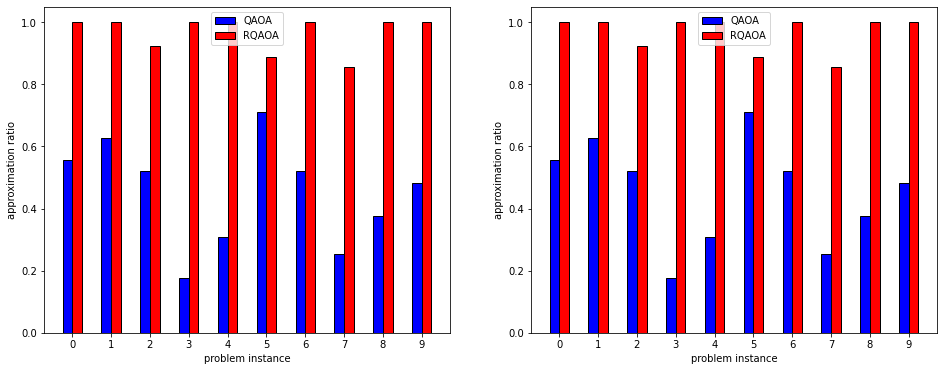

In [41]:
def draw(ax, d_l, d_r):
    x = np.arange(0, len(ar_qaoa)*2, 2)
    width=0.5
    x1 = x - width / 2
    x2 = x + width / 2
    ax.bar(x1, d_l, width=0.5, label='QAOA', color='blue', edgecolor='k', zorder=2)
    ax.bar(x2, d_r, width=0.5, label='RQAOA', color='red', edgecolor='k', zorder=2)
    ax.set_xlabel('problem instance')
    ax.set_ylabel('approximation ratio')
    ax.set_xticks(x)
    ax.set_xticklabels(x//2)
    ax.legend()

fig = plt.figure(figsize=(16,6))
draw(fig.add_subplot(1, 2, 1), ar_qaoa, ar_rqaoa_nc8)
draw(fig.add_subplot(1, 2, 2), ar_qaoa, ar_rqaoa_nc6)
plt.show()

FIG. 3: Approximation ratios achieved by the level-1 QAOA (blue) and RQAOA (red) for the Ising-type
Hamiltonian $H_n$  with n = 20 (left) and n = 20 (right). We consider 1 problem instances with random 3-regular graphs and random couplings $J_{p,q} = ±1$. The cutoff value for variable elimination was chosen as $n_c = 8$(left) and $n_c = 6$(right). The approximation ratio achieved by a given algorithm is defined as $\langle z|C_n|z \rangle /C_{max}$, where $z\in \{-1, 1\}^n$ is the algorithm’s output and $C_{max} = max_z\langle z|C_n|z \rangle$ where $C_n = \frac{1}{2}(\sum J_e-H_n)$.

因为n(20->8)和n(20->6)共用了一条n(20->8)的消元链路，所以两张图没啥区别...

## 项目总结

#### 简要总结一下您复现的论文

挺有意思的一种方法

RQAOA(recursive quantum approximate optimization algorithm):

对于Ising-like Hamiltonian$$H_n=\sum_{p,q\in E}J_{p,q}Z_pZ_q$$
通过QAOA优化到最小期望值后
$$min\langle \Psi^*|H_n|\Psi \rangle$$
$$=min\sum_{p,q\in E}J_{p,q}\langle \Psi^*|Z_pZ_q|\Psi \rangle$$
$$=min\sum_{p,q\in E}J_{p,q}M_{p,q}$$
就可以通过$M_{p,q}$的正负号推定节点p和q的相对关系（±1）

对于一个n节点的问题，用level-p的QAOA线路找节点间的相互关系，并根据该关系来代换掉其中某个相关节点来消减总节点数量，重复此过程直至子问题的节点数满足设定好的阈值$n_c\ll n$。

#### 您的复现结果

瞧瞧，简直一模一样

#### 创新点

创新！

#### 未来可继续研究的方向

① $n_c$对结果影响

In [ ]:
n = 128       # 节点数
nc_ul = 64    # nc上限
nc_ll = 4     # nc下限

graph = generate_graph(n)
g, Xi = rqaoa_recursion(graph, nc_ul)
res = []
while len(g.nodes) > nc_ll:
    g, Xi = rqaoa_recursion(g, len(g.nodes)-1, Xi)
    r = rqaoa_translate(g, Xi)
    l = []
    for k in r:
        if r[k] == -1:
            l.append(k)
    res.append((len(g.nodes), nx.cut_size(graph, l, weight='J'), l))

res  # list[(nc, maxcut, partition)]

② n对结果的影响/level-p的选取

③ 迭代过程中产生的无边节点剔除并随机赋值±1

④ 允许在单轮迭代中消去多个节点
- M：对$M_{i,j}$归一处理$\frac{|M_{i,j}|}{max(|M_e|)},e\in E$后，允许大于阈值的所有边的相关节点对被消去一个
- P：减少迭代次数
- I：阈值选取及是否会出现矛盾节点链

⑤ 换元过程中尽量减少新边产生